In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image
from tqdm import tqdm

In [2]:
class ELBO(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: Tensor) -> Tensor:
        q = self.encoder(x)
        z = q.rsample()

        return self.decoder(z).log_prob(x) + self.prior().log_prob(z) - q.log_prob(z)

In [4]:
class GaussianModel(zuko.flows.LazyDistribution):
    def __init__(self, features: int, context: int):
        super().__init__()

        self.hyper = nn.Sequential(
            nn.Linear(context, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * features),
        )

    def forward(self, c: Tensor) -> Distribution:
        phi = self.hyper(c)
        mu, log_sigma = phi.chunk(2, dim=-1)

        return Independent(Normal(mu, log_sigma.exp()), 1)


In [5]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((100_000,)).reshape((-1, 2))

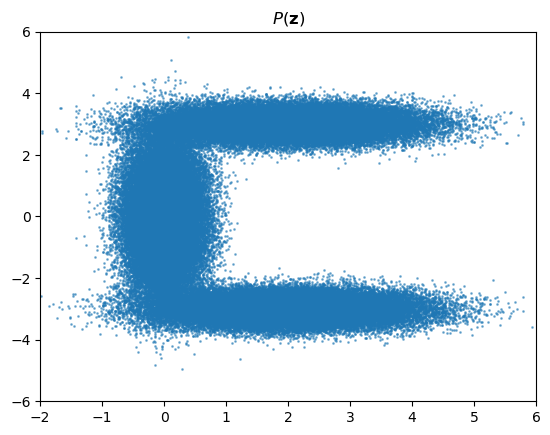

In [25]:
import matplotlib.pyplot as plt
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)

fig, ax = plt.subplots()
# 
ax.scatter(Z_train[:, 0], Z_train[:, 1], s=1, alpha=0.5)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{z})$');

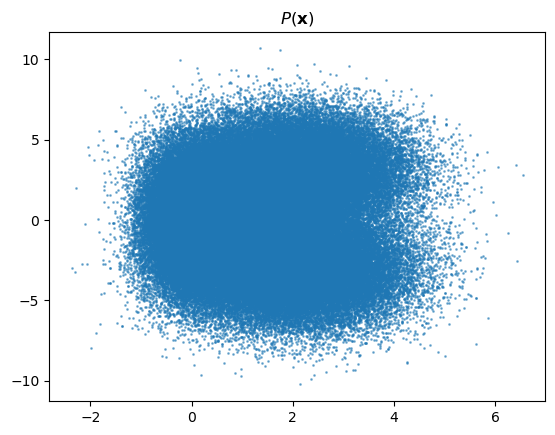

In [26]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]

fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.5)

ax.set_title(r'$P(\mathbf{x})$');

In [32]:
trainloader = data.DataLoader(Z_train, batch_size=256, shuffle=True)
encoder = GaussianModel(15, 2)
decoder = GaussianModel(2, 15)

prior = zuko.flows.MAF(
    features=15,
    transforms=6,
    hidden_features=(256, 256),
)
elbo = ELBO(encoder, decoder, prior)
optimizer = torch.optim.Adam(elbo.parameters(), lr=1e-3)

for epoch in (bar := tqdm(range(10))):
    losses = []

    for x in trainloader:
        

        loss = -elbo(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    bar.set_postfix(loss=losses.mean().item())

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:59<01:02, 12.51s/it, loss=4.02]

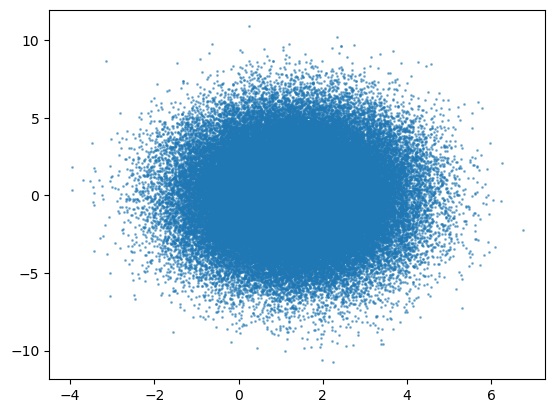

In [30]:
z = prior().sample((100000,))
x = decoder(z).sample()
plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.5)


In [16]:
x

tensor([3.8942, 1.7524])